In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os
from tinygp import kernels, GaussianProcess
import jax
from jax.scipy import linalg
import jax.numpy as jnp
import optax
from tqdm.notebook import trange, tqdm
from tinygp.noise import Diagonal
from tqdm import notebook
jax.config.update("jax_enable_x64", True)
plt.style.use(['science', 'no-latex', 'notebook', 'grid'])
import pickle
import pandas as pd
from CARPoolGP import *

# N-D model

We want a model that incorporates all of the approximate functional forms from the 1P set. 
$$
f(\theta) = f(\theta_1)f(\theta_2)...f(\theta_n)
$$
We can approximate the smooth mean functions in each parameter as a seperble polynomial. We can fit them directly in order to craft this function. We use a second order polynomial for simplicity. 

In [2]:
fin = open('Data/super_dict', 'rb')
super_dict = pickle.load(fin)
fin.close()
param_df = pd.read_csv('Data/params.txt', names = ['n', 'Om0', 's8', 'AASN1','AAGN1', 'AASN2', 'AAGN2', '_'])

In [3]:
# Gathering all the means of the Temperature 
names = list(super_dict.keys())
Qs = np.zeros((6, 11))
quantity = 'Ts'
for i, theta in enumerate(names):
    Q = 1e-6*np.array(super_dict[theta][quantity])[:, -20:]
    Qs[i] = np.mean(Q, axis=-1)

In [4]:
# Now we want to fit to all these models
model_p = np.zeros((6, 3))
for i, Q in enumerate(Qs):
    params  = np.unique(param_df[names[i]])
    model_p[i] = np.polyfit(params, Q, 2)

In [5]:
def toy_model(x, model_p):
    out = np.ones(len(x.T))
    for xi, m in zip(x, model_p):
        out *= np.polyval(m, xi)
    return out

In [6]:
lbs = list(param_df.min()[1:-1])
ubs = list(param_df.max()[1:-1])
from scipy.stats import qmc
sampler = qmc.Sobol(d=6, scramble=True, seed=1993)
sample = sampler.random_base2(m=9)
theta = qmc.scale(sample, lbs, ubs).T

test_sampler = qmc.Sobol(d=6, scramble=True, seed=1999)
test_sample = test_sampler.random_base2(m=9)
test_theta = qmc.scale(test_sample, lbs, ubs).T

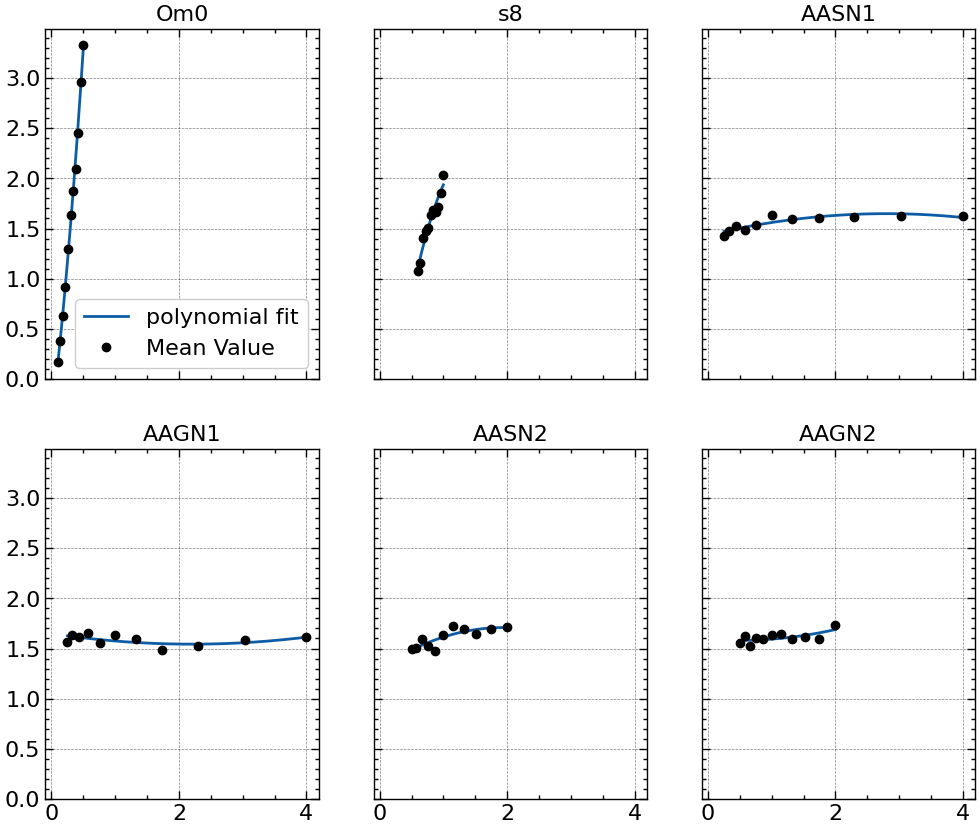

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12, 10))
for xii, m, i in zip(theta, model_p, np.arange(6)):
    xi = np.sort(xii)
    axs[i//3, i%3].plot(xi, np.polyval(m, xi), '-', label='polynomial fit')
    axs[i//3, i%3].plot(np.unique(param_df[names[i]]), Qs[i], 'ko', label='Mean Value')
    axs[i//3, i%3].set_title(names[i])
    axs[0, 0].legend()

In [9]:
theta.shape

(6, 512)

In [10]:
# Now we can create a model
T = toy_model(theta, model_p)
data = np.random.normal(T,5, theta.shape[1])
noise = T - data
T_test = toy_model(test_theta, model_p)

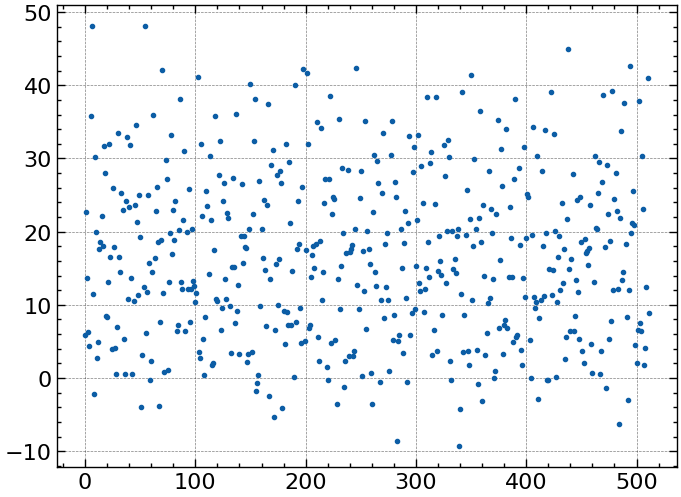

In [11]:
plt.plot(data, '.')

In [13]:
2**7

128

In [14]:
# Find the nearest neighbors for each data point
def nearest_distance(theta, surrogates):
    islands = np.zeros(len(surrogates.T))
    for t in theta.T:
        distance = np.linalg.norm( t- surrogates.T, axis=1)
        M = np.argmin(distance)
        islands[M] +=1
    return islands

f = 1.0
# Now we want to generate a set of surrogates which have a coarser grid
sampler = qmc.Sobol(d=6, scramble=True, seed=1992)
sample = sampler.random_base2(m=7)
theta_R = qmc.scale(sample, lbs, ubs).T
islands = nearest_distance(theta, theta_R)
theta_R = np.concatenate([S.repeat(int(I)).reshape(-1, int(I)).T for S, I in zip(theta_R.T, islands)]).T
surrogate_raw = toy_model(theta_R, model_p)
surrogate_data = surrogate_raw + f*noise + (1-f)*np.random.normal(0, 5, len(noise))

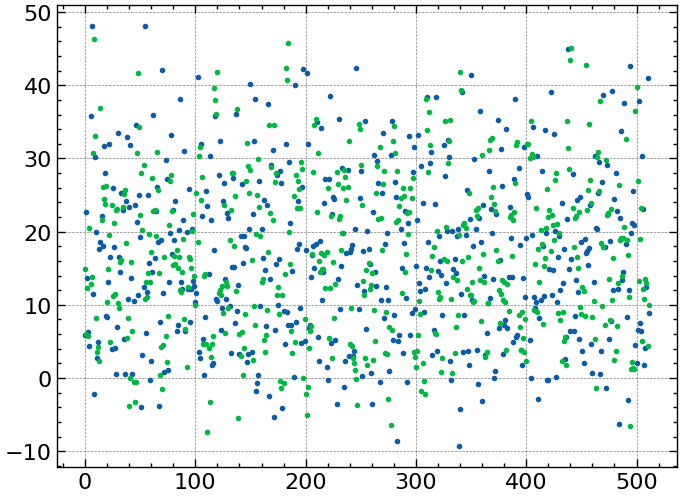

In [15]:
plt.plot(data, '.')
plt.plot(surrogate_data, '.')

In [16]:
class GPMixture(kernels.Kernel):
    """
    Custom kernel for carpool with \Delta P parameter
    """
    def __init__(self, amp, tau, delta_p=0):
        self.amp = jnp.atleast_1d(amp)
        self.tau = jnp.atleast_1d(tau)
        self.delta_p = jnp.atleast_1d(delta_p)

    def evaluate(self, X1, X2):
        x = jnp.atleast_1d(jnp.sqrt((X2 - X1 + self.delta_p)**2))
        return jnp.sum(self.amp * jnp.exp(-x**2*self.tau))

In [17]:
from tinygp import transforms
from tinygp.kernels import ExpSquared

In [18]:
def get_exp2kernel(params):
    return jnp.exp(params["log_amp"]) * transforms.Linear(jnp.exp(-params["log_tau"]), ExpSquared())

In [19]:
paramsCP = {
    "log_amp":1.0,
    "log_tau":jnp.ones(6),
    "log_jitter":1.0,
    "log_pl":-2.0}

kernel_func =  jax.tree_util.Partial(get_exp2kernel)

theta_QR = np.concatenate((theta.T, theta_R.T))
QR = np.concatenate((data, surrogate_data))
I = build_I(len(theta.T))

# # If you are getting nans, try making the LR smaller
opt = optax.sgd(learning_rate=1e-3)
opt_state = opt.init(paramsCP)
ls = []
ps = []
for i in trange(500):
    loss_val, grads = loss(paramsCP, kernel_func, theta_QR, QR, jitter=0, off_diag=I)
    updates, opt_state = opt.update(grads, opt_state)
    paramsCP = optax.apply_updates(paramsCP, updates)
    ps.append(paramsCP.values())
    ls.append(loss_val)

  0%|          | 0/500 [00:00<?, ?it/s]

/var/folders/2g/q1nb_42x629bp1zbjggj3xkw0000gp/T/ipykernel_18064/3810210104.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  axs[0].semilogx(np.array(ps_i)[:, i], label=list(paramsCP.keys())[i])


Text(0.5, 0, 'Iters')

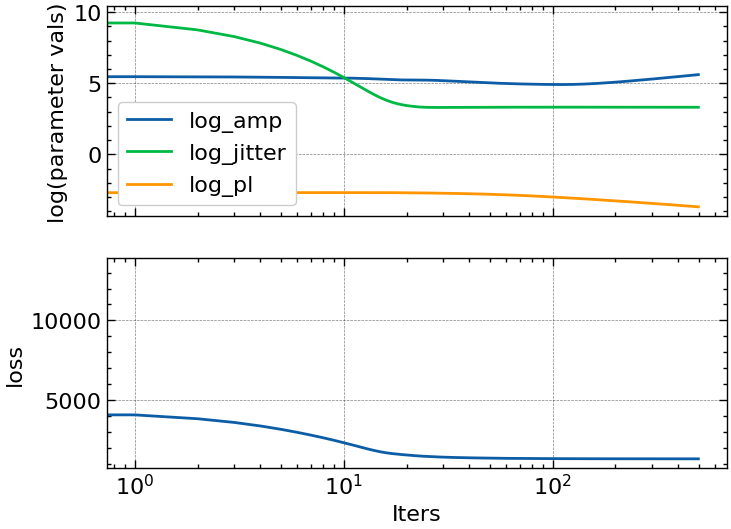

In [20]:
fig, axs = plt.subplots(nrows=2, sharex=True)
ps_i = [[list(p)[i] for i in range(len(paramsCP.keys()))] for p in ps]
axs[1].semilogx(ls)
for i in range(len(paramsCP.keys())):
    if i !=3:
        axs[0].semilogx(np.array(ps_i)[:, i], label=list(paramsCP.keys())[i])

axs[0].legend()
axs[0].set_ylabel('log(parameter vals)')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('Iters')

In [21]:
np.shape(test_theta)

(6, 512)

In [22]:
# Create the kernel
kernel = get_GPMixture(paramsCP)
p = 20 / (1 + np.exp(-paramsCP["log_pl"])) - 10
M = Mkernel(np.exp(-p))

# Generate the covariance matrices from the kernel
#r = 1/ (1 + np.exp(-paramsCP["pl"]))
noise =I * M(theta_QR, theta_QR) * np.exp(paramsCP['log_jitter']) + np.eye(2*len(theta.T))*jnp.exp(paramsCP['log_jitter'])
cov = kernel(theta_QR, theta_QR)+noise
pred_cov = kernel(np.concatenate((test_theta.T, theta_QR)), np.concatenate((test_theta.T, theta_QR)))

# Predict the mean and cov
pred_meanCP, pred_varCP = predict(QR, cov, pred_cov, 0)

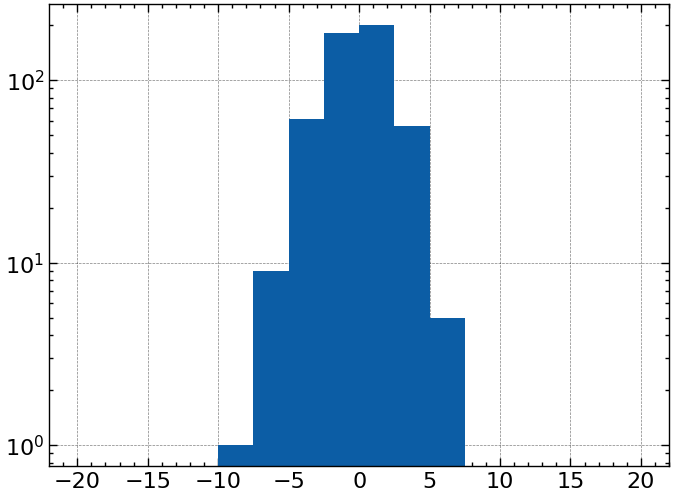

In [23]:
_ = plt.hist(pred_meanCP -T_test, bins=np.linspace(-20, 20, 17), log=True, density=False)

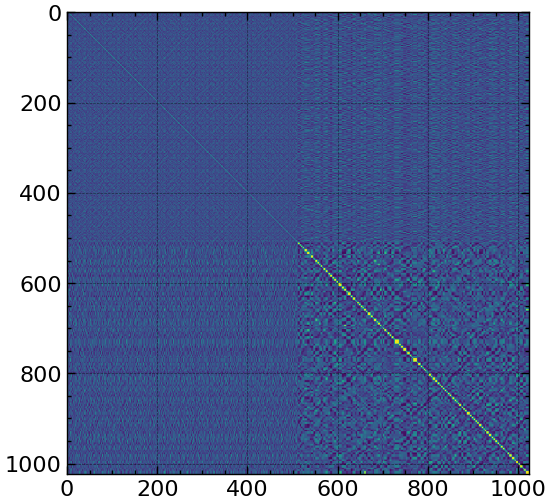

In [24]:
plt.imshow(cov)

# Compared to more data

In [25]:
sampler = qmc.Sobol(d=6, scramble=True, seed=1993)
sample = sampler.random_base2(m=10)
double_theta = qmc.scale(sample, lbs, ubs).T
T = toy_model(double_theta, model_p)
double_data = np.random.normal(T,5, double_theta.shape[1])

paramsGP = {
    "log_amp":1.0,
    "log_tau":jnp.ones(6),
    "log_jitter":0.5}

kernel_func =  jax.tree_util.Partial(get_exp2kernel)

# # If you are getting nans, try making the LR smaller
opt = optax.sgd(learning_rate=1e-3)
opt_state = opt.init(paramsGP)
ls = []
ps = []
for i in trange(500):
    loss_val, grads = loss(paramsGP, kernel_func, double_theta.T, double_data)
    updates, opt_state = opt.update(grads, opt_state)
    paramsGP = optax.apply_updates(paramsGP, updates)
    ps.append(paramsGP.values())
    ls.append(loss_val)

  0%|          | 0/500 [00:00<?, ?it/s]

In [26]:
# Create the kernel
kernel = get_GPMixture(paramsGP)
noise = np.eye(len(double_theta.T))*jnp.exp(paramsGP['log_jitter'])
cov = kernel(double_theta.T, double_theta.T)+noise
pred_cov = kernel(np.concatenate((test_theta.T, double_theta.T)), np.concatenate((test_theta.T, double_theta.T)))

# Predict the mean and cov
pred_meanGP, pred_varGP = predict(double_data, cov, pred_cov, 0)

In [42]:
print(np.sum((pred_meanGP - T_test)**2/np.diag(pred_varGP)))
print(np.sum((pred_meanCP - T_test)**2/np.diag(pred_varCP)))

4502.361559761276
965.7052994422215


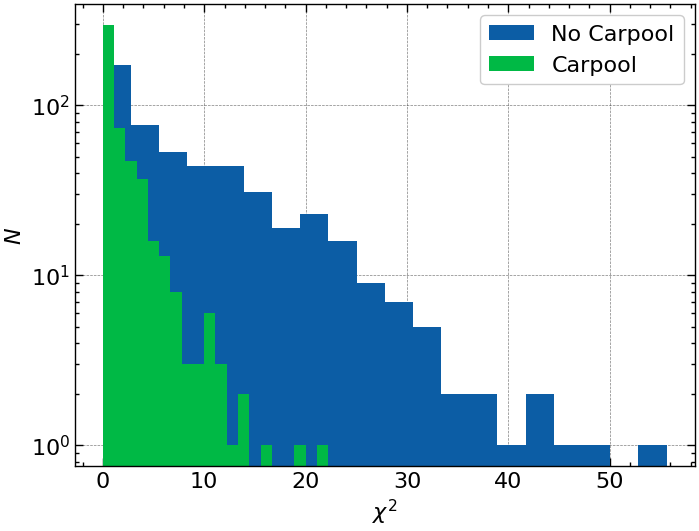

In [44]:
_ = plt.hist((pred_meanGP - T_test)**2/np.diag(pred_varGP), bins=20, log=True, label='No Carpool')
_ = plt.hist((pred_meanCP - T_test)**2/np.diag(pred_varCP), bins=20, log=True, label='Carpool')
plt.xlabel('$\chi^2$')
plt.ylabel('$N$')
plt.legend()

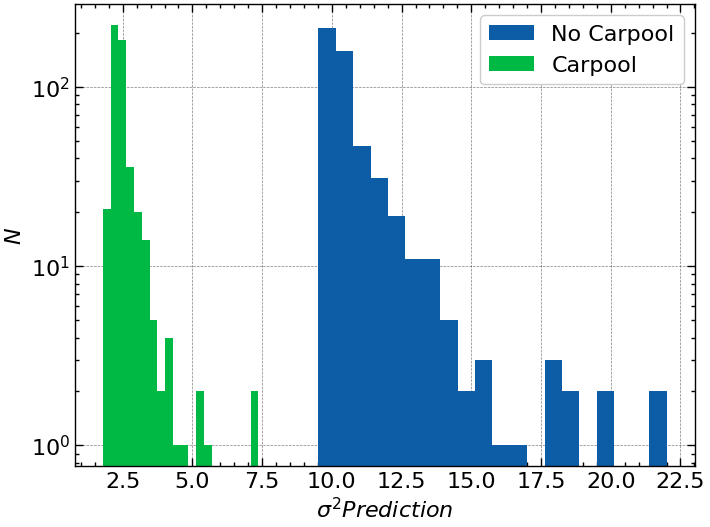

In [35]:
_ = plt.hist(np.diag(pred_varGP), bins=20, log=True, label='No Carpool')
_ = plt.hist(np.diag(pred_varCP), bins=20, log=True, label='Carpool')
plt.xlabel('$\sigma^2 Prediction$')
plt.ylabel('$N$')
plt.legend()

(-11.0, 3.0)

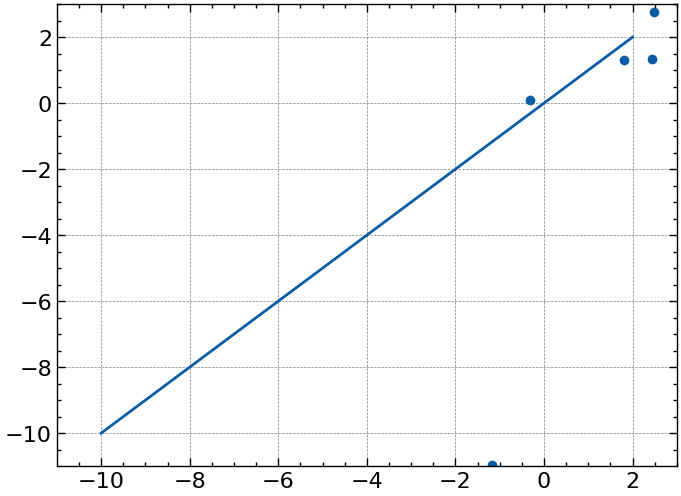

In [31]:
plt.scatter(paramsCP['log_tau'], paramsGP['log_tau'])
plt.plot(np.arange(-10, 3), np.arange(-10, 3))
plt.xlim(-11, 3)
plt.ylim(-11, 3)

In [226]:
A = np.cov(theta) 
lam = np.mean(theta, axis=1)
e = np.linalg.eig(A - lam)[0]
split = np.array([np.dot(e, t) for t in theta.T])

In [ ]:
L = 4
G = np.zeros_like(theta.T)

levels = []
for i in range(0, L+1):
    level = np.arange(2**i)/(2**i)*2**L
    levels.append(level.astype(int))

for i in range(4):
    bigger = []
    smaller = []
        t = theta[:, G==index]
        A = np.cov(t) 
        lam = np.mean(t, axis=1)
        e = np.linalg.eig(A - lam)[0]
        split = np.array([np.dot(e, t) for t in t.T])
        G[split>0]  = 1
        G[split<0]  = 0

In [295]:
levels

[array([0]),
 array([0, 8]),
 array([ 0,  4,  8, 12]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])]

In [337]:
args.shape

(64,)

In [340]:
L = 4
G = np.zeros(len(theta.T))

levels = []
for i in range(0, L+1):
    level = np.arange(2**i)/(2**i)*2**L
    levels.append(level.astype(int))

for i, level in enumerate(levels):
    for index in level:
        args = G==index
        t = theta[:, args]
        A = np.cov(t) 
        lam = np.mean(t, axis=1)
        e = np.linalg.eig(A - lam)[0]
        split = np.array([np.dot(e, t) for t in t.T])

        G[split>0]  = index + int(16/2**(i+1))
        G[split<0]  = index


IndexError: boolean index did not match indexed array along dimension 0; dimension is 64 but corresponding boolean dimension is 15

In [341]:
G

array([8., 8., 8., 8., 8., 8., 8., 0., 8., 0., 8., 8., 8., 8., 0., 8., 0.,
       8., 8., 8., 8., 0., 8., 8., 8., 0., 8., 8., 8., 8., 0., 8., 8., 0.,
       8., 0., 8., 8., 0., 8., 8., 8., 0., 8., 8., 0., 8., 8., 8., 0., 8.,
       8., 8., 8., 0., 8., 8., 8., 0., 8., 8., 8., 8., 8.])